<a href="https://colab.research.google.com/github/mahapara2411/devopsgit/blob/main/Price_Elasticity_and_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels.formula.api as smf
import io

In [4]:
from google.colab import files
uploaded = files.upload()

Saving OnlineRetail.csv to OnlineRetail.csv


In [5]:
df = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')

In [6]:
print('The dataset has orders made from {} to {}'.format(min(df['InvoiceDate']),
                                                         max(df['InvoiceDate'])))

The dataset has orders made from 1/10/2011 10:04 to 9/9/2011 9:52


In [7]:
df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [8]:
df = df[(df['Quantity']>0)&(df['UnitPrice']>0)]

In [9]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

In [10]:
df[df['CustomerID'].isna()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom


Since customer id is not needed for this analysis, and quantity and unit price have no missing values, rows with missing values won't be removed.

**Examining items data**

Having a look at number of prices for each item to decide which items to use for price elasticity analysis. We would want items that have had quite some variation in price and been sold in quite a large number of orders

In [11]:
df_items = df.groupby('StockCode')\
             .agg({'Description': 'first',
                   'UnitPrice': ['nunique', 'count', 'mean', 'min', 'max']})\
             .reset_index()
# rename columns - merge multi-level columns from agg
df_items.columns = [level1+level2.title() if level2!='' else level1\
                    for level1, level2 in df_items.columns ]
df_items.sort_values(by=['UnitPriceNunique', 'UnitPriceCount'],
                     ascending=False, inplace=True)
df_items.head(10)

,StockCode,DescriptionFirst,UnitPriceNunique,UnitPriceCount,UnitPriceMean,UnitPriceMin,UnitPriceMax
3911,DOT,DOTCOM POSTAGE,686,706,292.137068,0.35,4505.17
3912,M,Manual,131,321,230.860530,0.06,4287.63
3914,POST,POSTAGE,53,1126,31.076581,0.55,8142.75
2845,79321,CHILLI LIGHTS,15,670,6.789522,3.82,17.88
2670,47566,PARTY BUNTING,14,1706,5.794273,3.75,15.79
406,21166,COOK WITH WINE METAL SIGN,14,734,2.386090,1.40,4.21
412,21175,GIN + TONIC DIET METAL SIGN,13,818,2.766174,1.40,4.96
151,20685,DOORMAT RED RETROSPOT,13,699,8.951516,4.58,16.98
906,21929,JUMBO BAG PINK VINTAGE PAISLEY,12,873,2.677663,1.65,5.06
1031,22111,SCOTTIE DOG HOT WATER BOTTLE,12,791,5.794488,4.25,16.67


For each item, quantity sold will be aggregated to get the total demand at each price for the entire year. Regression will then be used to estimate price elasticity of demand of each item. Given that for regression, roughly 10 observations would be needed to estimate a parameter, the analysis would only use items with at least 10 prices

**Aggregating price and quantity for selected items**

In [12]:
items_to_remove = ['DOTCOM POSTAGE', 'Manual', 'POSTAGE']
df_items_sub = df_items[(df_items['UnitPriceNunique']>=10)\
                         &(~df_items['DescriptionFirst'].isin(items_to_remove))]

# subset items with at least 10 unit prices
df_sub = df[df['StockCode'].isin(df_items_sub['StockCode'].tolist())]\
                           .reset_index(drop=True)\
                           .drop(columns=['InvoiceNo', 'InvoiceDate', 'CustomerID', 'Country'])

# Get total quantity at each unit price for each item
df_agg = df_sub.groupby(['StockCode', 'UnitPrice'])['Quantity']\
               .sum()\
               .reset_index()\
               .rename(columns={'Quantity': 'TotalQuantity'})

**Estimating price elasticity of demand**

**Plot demand curve**

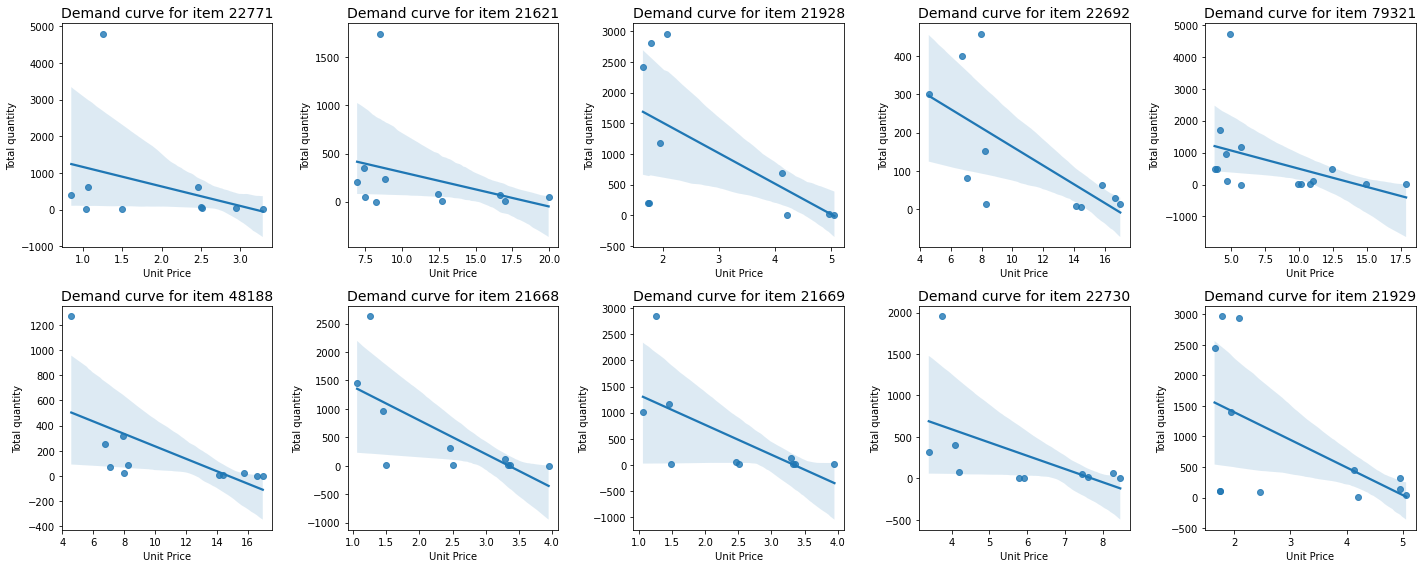

In [13]:
def plot_demand_curve(df, item_col, quantity_col, price_col, n=10):
    '''randomly select n items from a dataframe to plot each
       item's demand curve
    '''
    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    ax = ax.ravel()
    
    # randomly choose n items to be plotted
    items_to_plot = random.sample(df[item_col].unique().tolist(), n)
    
    # plot demand vs unit price for the n items
    for i, item in enumerate(items_to_plot):
        sns.regplot(x=price_col, y=quantity_col, data=df[df[item_col]==item], ax=ax[i])
        ax[i].set_title('Demand curve for item '+item, fontsize=14)
        ax[i].set_xlabel('Unit Price')
        ax[i].set_ylabel('Total quantity')
    plt.tight_layout()
    plt.show()

plot_demand_curve(df_agg, 'StockCode', 'TotalQuantity', 'UnitPrice')

**Fit linear regression to estimate elasticity**

Assuming a linear relationship between price and quantity, we have the following linear regression function:
quantity = intercept + slope price, or Y = a + b X
Price elasticity of demand, which is the percent change in quantity over percent change in price, can then be calculated using:
elasticity = (dY/Y) / (dX/X) = dY/dX (Y/X) = b (Y/X)
That is, elasticity = slope * (mean quantity / mean price)

In [14]:
def get_elasticity(df, quantity_col, price_col):
    '''fits linear regression for one item, quantity_col is
       used as outcome variable and price_col as independent variable
       returns intercept, slope, p-value of regression, and also
       price elasticity 
    '''
    # regress quantity on price to estimate price elasticity
    reg_fit = smf.ols(formula=quantity_col+' ~ '+price_col, data=df).fit()
    
    # extract intercept slope and p-value from model parameters
    intercept = reg_fit.params['Intercept']
    slope = reg_fit.params[price_col]
    p_value = reg_fit.pvalues.loc[price_col] 
    
    # calculate elasticity - slope*(mean price/mean quantity)
    elasticity = slope * (df[price_col].mean() / df[quantity_col].mean())
    
    return intercept, slope, p_value, elasticity

In [15]:
def get_multiple_elasticity(df, item_id_col, quantity_col, price_col):
    '''runs linear regression for multiple items in a df
       returns a separate df with item id, elasticity,
       p-value, and whether price is a significant predictor of 
       quantity
    '''
    elasticity_results = []
     
    for item_id in df[item_id_col].unique():
        elasticity = {}
        # subset rows with item_id
        df_single_item = df[df[item_id_col]==item_id]
        # store intercept slope and p-value in dict
        elasticity['StockCode'] = item_id
        elasticity['Intercept'], elasticity['Slope'], elasticity['PValue'], elasticity['Elasticity']\
               = get_elasticity(df_single_item, quantity_col, price_col)
        elasticity_results.append(elasticity)
        
        df_elasticity = pd.DataFrame(elasticity_results).set_index('StockCode')
        # use p <.1 as cutoff for significance
        df_elasticity['Significant'] = df_elasticity['PValue'].apply(lambda x:
                                                                     'Yes' if x < 0.1 else 'No')
        
    return df_elasticity

In [17]:
# get elasticity for all items in df_agg
df_elasticity = get_multiple_elasticity(df_agg, 'StockCode', 'TotalQuantity', 'UnitPrice')
df_elasticity = df_elasticity.merge(df[['StockCode', 'Description']].drop_duplicates(), 
                                    on='StockCode', how='left')
df_elasticity.head()

,StockCode,Intercept,Slope,PValue,Elasticity,Significant,Description
0,17003,5488.896843,-8099.991966,0.061663,-1.380680,Yes,BROCADE RING PURSE
1,20685,993.951295,-64.769416,0.022646,-2.157714,Yes,DOORMAT RED RETROSPOT
2,20712,1981.175228,-342.385821,0.171728,-1.027192,No,JUMBO BAG WOODLAND ANIMALS
3,21033,371.733464,-60.057058,0.051504,-1.307709,Yes,JUMBO BAG CHARLIE AND LOLA TOYS
4,21166,1243.060670,-224.167178,0.574625,-0.679163,No,COOK WITH WINE METAL SIGN


**Visualizing price elasticity**

**Plot elasticity of 10 most elastic and 10 most inelastic items**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


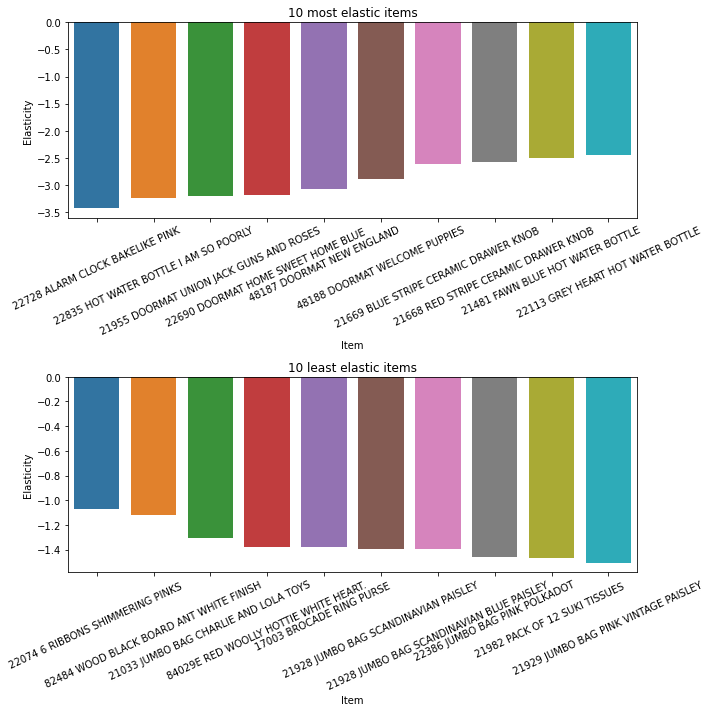

In [18]:
# subset items with significant p-value
df_elasticity = df_elasticity[df_elasticity['Significant']=='Yes']
df_elasticity['Item'] = df_elasticity[['StockCode', 'Description']]\
                                     .apply(lambda x: ' '.join(x), axis=1)

# make df for most and least elastic items
df_most_elastic = df_elasticity.sort_values(by='Elasticity')[:10]
df_least_elastic = df_elasticity.sort_values(by='Elasticity',
                                             ascending=False)[:10]

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(x='Item', y='Elasticity', data=df_most_elastic, ax=axes[0])
axes[0].set_title('10 most elastic items')
sns.barplot(x='Item', y='Elasticity', data=df_least_elastic, ax=axes[1])
axes[1].set_title('10 least elastic items')
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(25)
plt.tight_layout()
plt.show()

Overall, items in this dataset are quite price elastic. The absolute values of even the least elastic items are greater than 1. This makes sense given that this dataset mainly contains small, non-necessity retail items.

**Price optimization**

The dataset doesn't include cost information. Synthetic unit cost - 80% of mean price of each item will be used for price optimization.

In [19]:
# calculate unit cost (0.8*mean unit price) and add to elasticity df
df_elasticity = df_agg.groupby('StockCode')['UnitPrice']\
                      .agg(lambda x: x.mean()*0.8)\
                      .reset_index()\
                      .rename(columns={'UnitPrice': 'UnitCost'})\
                      .merge(df_elasticity, on='StockCode')

**Calculate price that maximizes profit for each item**

We have the following functions for quantity and profit:
quantity = intercept + slope * unit price
profit = (unit price - unit cost) * quantity
therefore, profit = (unit price - unit cost) (intercept + slope unit price)
To calculate profit-maximizing price, we would differentiate the profit function and make the derivative equal to 0
Solving the derivative = 0 will give us:
profit-maximizing price = (-intercept + slope unit cost) / (2 slope)

In [20]:
def get_optimal_price(row):
    '''calculates profit maximizing price using marginal cost and elasticity
    '''
    return (-row['Intercept']+row['Slope']*row['UnitCost'])/(2*row['Slope'])
    
df_elasticity['OptimalPrice'] = df_elasticity.apply(get_optimal_price, axis=1)


**Plot estimated profit curve**

The following function will be used to plot profit curve using estimated elasticity and unit price
profit = (unit price - unit cost) (intercept + slope unit price)

In [21]:
def plot_estimated_profit(df, n=10):
    '''randomly selects n items from df to plot
       estimated profit curve for each item,
       df needs to have StockCode, UnitCost, Intercept, 
       Slope, and OptimalPrice columns
    '''
    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    ax = ax.ravel()
    
    # randomly choose n items to be plotted
    items_to_plot = random.sample(df['StockCode'].unique().tolist(), n)
    
    # for each item in the randomly chosen list
    for i, item in enumerate(items_to_plot):
        price = np.linspace(0, 15, 1000)
        # extract the parameters, unit cost, and optimal price of the item
        cols = ['UnitCost', 'Intercept', 'Slope', 'OptimalPrice']
        row = df[df['StockCode']==item][cols].values
        # estimated profit function
        est_profit = (price - row[0][0]) * (row[0][1] + row[0][2] * price)
        
        # plot estimated profit against price
        ax[i].plot(price, est_profit)
        ax[i].axvline(x=row[0][3], c='k')
        ax[i].set_title('Estimated profit for item '+item, fontsize=14)
        ax[i].set_xlabel('Price')
        ax[i].set_ylabel('Profit')
    plt.tight_layout()
    plt.show()

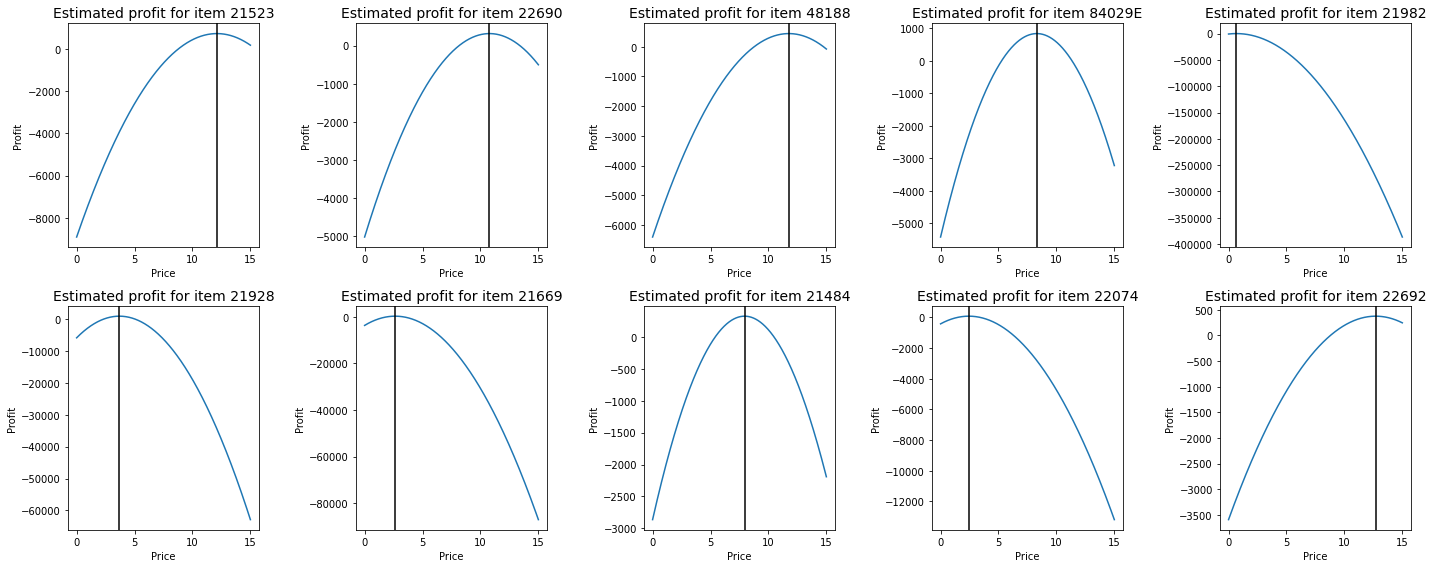

In [22]:
plot_estimated_profit(df_elasticity)